In [1]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## utils

In [2]:
def show_result(num_epoch):
    test_images = sess.run(G, {z: z_, isTrain:False})
    
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    
    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    plt.show()

## model

In [3]:
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        init_w = tf.random_normal_initializer(mean=0.0, stddev=1.0)
        init_b = tf.constant_initializer(1.0)
        
        # layer1
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid', 
                                           kernel_initializer=init_w, bias_initializer=init_b)
        h1 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv1, training=isTrain), alpha=0.2)
        
        # layer2
        conv2 = tf.layers.conv2d_transpose(h1, 512, [4, 4], strides=(2, 2), padding='same', 
                                           kernel_initializer=init_w, bias_initializer=init_b)
        h2 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv2, training=isTrain), alpha=0.2)
        
        # layer3
        conv3 = tf.layers.conv2d_transpose(h2, 256, [4, 4], strides=(2, 2), padding='same', 
                                           kernel_initializer=init_w, bias_initializer=init_b)
        h3 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv3, training=isTrain), alpha=0.2)
        
        # layer4
        conv4 = tf.layers.conv2d_transpose(h3, 128, [4, 4], strides=(2, 2), padding='same', 
                                           kernel_initializer=init_w, bias_initializer=init_b)
        h4 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv4, training=isTrain), alpha=0.2)
        
        # output layer
        conv5 = tf.layers.conv2d_transpose(h4, 1, [4, 4], strides=(2, 2), padding='same', 
                                           kernel_initializer=init_w, bias_initializer=init_b)
        o = tf.nn.tanh(conv5)
        
        return o
    
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        init_w = tf.random_normal_initializer(mean=0.0, stddev=1.0)
        init_b = tf.constant_initializer(1.0)
        
        # layer1
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same', 
                                 kernel_initializer=init_w, bias_initializer=init_b)
        h1 = tf.nn.leaky_relu(conv1, alpha=0.2)
        
        # layer2
        conv2 = tf.layers.conv2d(h1, 256, [4, 4], strides=(2, 2), padding='same', 
                                 kernel_initializer=init_w, bias_initializer=init_b)
        h2 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv2, training=isTrain), alpha=0.2)
        
        # layer3
        conv3 = tf.layers.conv2d(h2, 512, [4, 4], strides=(2, 2), padding='same', 
                                 kernel_initializer=init_w, bias_initializer=init_b)
        h3 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv3, training=isTrain), alpha=0.2)
        
        # layer4
        conv4 = tf.layers.conv2d(h3, 1024, [4, 4], strides=(2, 2), padding='same', 
                                 kernel_initializer=init_w, bias_initializer=init_b)
        h4 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv4, training=isTrain), alpha=0.2)
        
        # output layer
        conv5 = tf.layers.conv2d(h4, 1, [4, 4], strides=(1, 1), padding='valid', 
                                 kernel_initializer=init_w, bias_initializer=init_b)
        o = tf.nn.sigmoid(conv5)
        
        return o, conv5

## layers vs nn (ex. conv)
- layers : inputs 만 4-d tensor로 입력
- nn : inputs, filter, stride 모두 4-d로 입력

## layers
- tf.layers.conv2d
  - inputs :  tensor
  - filters : filter의 수
  - kernel_size : int or list, kernel의 h, w
  - strides : int or list, h, w의 strides
  - padding : 'same' or 'valid'
  
  
- tf.layers.conv2d_transpose
  - inputs : tensor
  - filters : filter의 수
  - kernel_size : int or list, kernel의 h, w
  - strides : int or list, stirdes of (h, w)
  - padding : 'same' or 'valid'
  
  
- tf.layers.batch_normalization()
  - inputs : tensor
  - axis : normalize 축
  - ??

## nn
- tf.nn.conv2d
  - input : 4d tensor [b, h, w, c]
  - filter : 4d tensor [h, w, in_channel, out_channel]
  - stride : length 4 of list [b, h, w, c]
  - padding : 'same' or 'valid'
  
  
- tf.nn.conv2d_transpose
  - input : 4d tensor [b, h, w, c]
  - filter : 4d tensor [h, w, in, out]
  - output_shape : 1d tensor output shape 표시
  - stride : length 4 of list [1, h, w, 1]
  - padding : 'same'

## load dataset

In [4]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True, reshape=[])

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Train

In [5]:
## set parameters
batch_size = 100
lr = 0.0002
train_epoch = 20

In [6]:
## set variable
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(tf.bool)

In [7]:
## set model
G = generator(z, isTrain)

D_real, D_real_logit = discriminator(x, isTrain)
D_fake, D_fake_logit = discriminator(G, isTrain, reuse=True)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d instead.


In [8]:
## set loss
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logit, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.ones([batch_size, 1, 1, 1])))

## loss
- tf.nn.sigmoid_cross_entropy_with_logits
  - logits : logits 값 (log(확률 / 1 - 확률))
  - labels : 실제 label 확률 값

In [9]:
## trainable variable 
T_var = tf.trainable_variables()
G_var = [var for var in T_var if var.name.startswith('generator')]
D_var = [var for var in T_var if var.name.startswith('discriminator')]

In [10]:
## set optimizer
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_var)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_var)

- Collections : Variable의 그룹 리스트
  - tf.get_collections를 이용해 해당 collection의 key에 해당되는 variable들 반환
  - tf.add_to_collection(key, variable) : collection에 해당 variable을 추가시킬 때 사용
  - 종류 : tf.GraphKeys
  
  
  - 사용 예
    1. regularization : GraphKeys.REGULARIZATION_LOSSES 에 정규화할 목록 저장
    2. trainable_variable 호출 : GraphKeys.TRAINABLE_VARIABLES 에 학습되는 변수 저장
      tf.trainable_variable()로 학습될 변수 호출
    3. tf.train.Saver() : GraphKeys.GLOBAL_VARIABLES : 모든 variable 변수를 호출
    4. tf.global_variables_initializer() : GraphKeys.GLOBAL_VARIABLES를 이용해 모든 variable 초기화
    5. tf.nn.batch_normalization : moving_mean과 moving_var이 GraphKeys.UPDATE_OPS에 저장되어 있음
      해당 값을 불러와서 moving_mean, moving_Var 업데이트

- tf.control_dependencies() : 안에 있는 opt를 실행한 후, 아래 opt 실행

## Sess

In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [12]:
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5

In [13]:
np.random.seed(int(time.time()))

[1/20] loss_g: 26.048, loss_d: 66.601


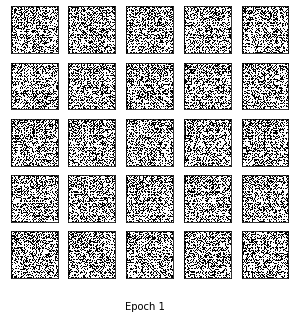

[1/20] loss_g: 47.194, loss_d: 29.430


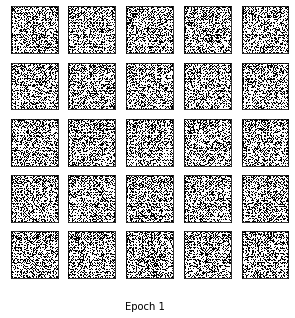

[1/20] loss_g: 63.921, loss_d: 20.048


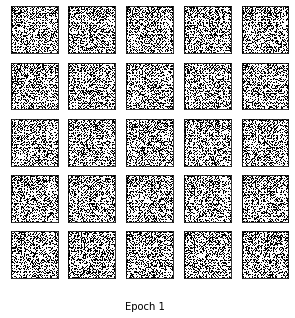

[1/20] loss_g: 73.628, loss_d: 15.447


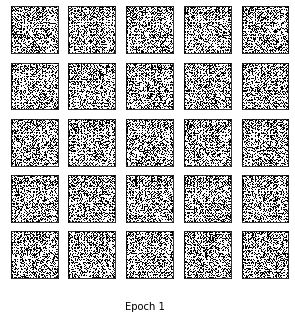

[1/20] loss_g: 80.831, loss_d: 12.680


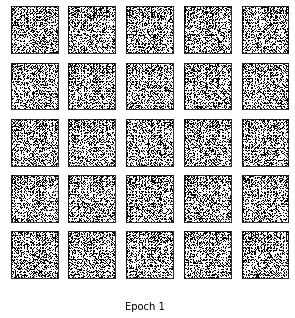

KeyboardInterrupt: 

In [14]:
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    
    for iter in range(mnist.train.num_examples // batch_size):
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        
        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)
        loss_g_, _ = sess.run([G_loss, G_optim], {x: x_, z: z_, isTrain: True})
        G_losses.append(loss_g_)
        
        if iter % 10 == 0:
            print('[%d/%d] loss_g: %.3f, loss_d: %.3f' % ((epoch+1), train_epoch, np.mean(G_losses), np.mean(D_losses)))
            show_result((epoch + 1))